First, exploring can we do this with rawtag, corrtag:

In [1]:
from costools import timefilter

import calcos 

from astropy.io import fits      
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

from astroquery.mast import Observations

The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


In [2]:
data_dir = './data/'
output_dir = './output/'

In [3]:
pl = Observations.get_product_list(Observations.query_criteria(obs_id = 'lb3q01070'))
mask_ = np.where((pl["productSubGroupDescription"] == "CORRTAG_A") | (pl["productSubGroupDescription"] == "CORRTAG_B"))
Observations.download_products(pl[mask_], data_dir, cache=False)

Local Path,Status,Message,URL
str58,str8,object,object
./data/mastDownload/HST/lb3q01kbq/lb3q01kbq_corrtag_a.fits,COMPLETE,None,None
./data/mastDownload/HST/lb3q01kbq/lb3q01kbq_corrtag_b.fits,COMPLETE,None,None


In [4]:
!rm output/temp*_corrtag_a.fits

timefilter.TimelineFilter(data_dir+ "mastDownload/HST/lb3q01kbq/" +"lb3q01kbq_corrtag_a.fits", output_dir+"temp2_corrtag_a.fits", # your input names will be different
                              "sun_alt > -40", verbose = True)

Input file /Users/nkerman/Projects/COS-Notebooks/DayNight/data/mastDownload/HST/lb3q01kbq/lb3q01kbq_corrtag_a.fits
sun_alt > -40 flagged as bad
EXPTIME changed from 1420.192 to 724.99194
New GTI extension appended
Writing to /Users/nkerman/Projects/COS-Notebooks/DayNight/output/temp2_corrtag_a.fits


In [5]:
orig1 = Table.read(data_dir+ "mastDownload/HST/lb3q01kbq/" +"lb3q01kbq_corrtag_a.fits", hdu =1)
temp1 = Table.read(output_dir+"temp2_corrtag_a.fits", hdu =1)
orig3 = Table.read(data_dir+ "mastDownload/HST/lb3q01kbq/" +"lb3q01kbq_corrtag_a.fits", hdu =3)
temp3 = Table.read(output_dir+"temp2_corrtag_a.fits", hdu =3)

print(Table.read(data_dir+ "mastDownload/HST/lb3q01kbq/" +"lb3q01kbq_corrtag_a.fits", hdu =2), "\n")
print(Table.read(output_dir+"temp2_corrtag_a.fits", hdu =2), "\n")

len(orig1),len(temp1)

 START    STOP  
seconds seconds 
------- --------
    0.0 1420.192 

 START    STOP  
seconds seconds 
------- --------
    0.0 1420.192 



(154071, 154071)

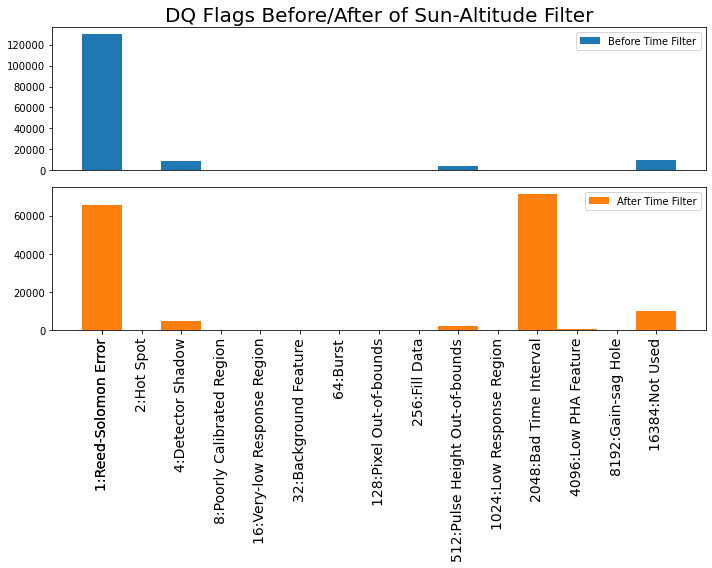

In [6]:
bins_ = np.arange(0,16)
xticks_ = [0] + list(np.linspace(start = 0, stop = 14 ,num = 15, dtype = int))
xtick_labels_ = [0] + list(np.logspace(start = 0, stop = 14, base=2, num = 15, dtype = int))
meanings = ['No Anomalies', 'Reed-Solomon Error', 'Hot Spot', 'Detector Shadow', 'Poorly Calibrated Region', # What each power of 2 means in order
            'Very-low Response Region', 'Background Feature', 'Burst', 'Pixel Out-of-bounds', 'Fill Data', 
            'Pulse Height Out-of-bounds', 'Low Response Region', 'Bad Time Interval', 'Low PHA Feature', 
           'Gain-sag Hole', 'Not Used']
xtick_labels_ = [str(bt)+":"+ mn for bt, mn in zip(xtick_labels_, meanings)]

np.warnings.filterwarnings('ignore')

fig, (ax0,ax1) = plt.subplots(2,1,figsize = (10,8))
ax0.hist(np.nan_to_num(np.log2(orig1["DQ"]), neginf=0), bins = bins_, alpha = 1, 
         color = 'C0', label = "Before Time Filter")
ax1.hist(np.nan_to_num(np.log2(temp1["DQ"]), neginf=0),bins = bins_, alpha = 1, 
         color = 'C1', label = "After Time Filter")
ax0.set_xticks([])
ax1.set_xticks(np.add(0.5,xticks_))
ax1.set_xticklabels(xtick_labels_, rotation = 90, fontsize = 14)
ax0.legend()
ax1.legend()
ax0.set_title("DQ Flags Before/After of Sun-Altitude Filter", size = 20)
plt.tight_layout()

In [16]:
fits.getheader(data_dir+ "mastDownload/HST/lb3q01kbq/" +"lb3q01kbq_corrtag_a.fits",ext=1)["SDQFLAGS"],fits.getheader(output_dir+ "temp2_corrtag_a.fits",ext=1)["SDQFLAGS"]

(8346, 8346)

In [28]:
def interpret_sdq(flags):
    print("Bit\tFlagged?\tMeaning")
    for i, char in enumerate(bin(flags)[::-1][:-2]):
        print(2**(i),"\t", bool(int(char)),"\t", meanings[i+1])

interpret_sdq(8346)

Bit	Flagged?	Meaning
1 	 False 	 Reed-Solomon Error
2 	 True 	 Hot Spot
4 	 False 	 Detector Shadow
8 	 True 	 Poorly Calibrated Region
16 	 True 	 Very-low Response Region
32 	 False 	 Background Feature
64 	 False 	 Burst
128 	 True 	 Pixel Out-of-bounds
256 	 False 	 Fill Data
512 	 False 	 Pulse Height Out-of-bounds
1024 	 False 	 Low Response Region
2048 	 False 	 Bad Time Interval
4096 	 False 	 Low PHA Feature
8192 	 True 	 Gain-sag Hole
